<a href="https://colab.research.google.com/github/RefiloeJ/Biochemical-engineering-notes/blob/master/Group_9_CPB410_Simulation_Project_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
import sympy as sy

# Blending Process Response

The liquid storage system shown has two inlet streams ($w_{1}$ and $w_{2}$) and an outlet stream ($w_{3}$). The tank is $\textbf{2.5 m high and 2 m}$ in diameter. The liquid density is $\textbf{800 kg/m3}$. You may assume that the density is constant. The nominal operating conditions are as follows:

$$ \bar{w_{1}} = 120 \ \mathrm{kg/min} $$

$$ \bar{w_{2}} = 100 \ \mathrm{kg/min} $$

The equations governing the dynamic behaviour of the system are as follows:

$$ \rho A \frac{dh}{dt} = w_{1} + w_{2} -w_{3}$$ 

$$ w_{3} = C_{v}\sqrt{h} $$

In addition it is known that there is leak located 1 m from the base of the tank. The volumetric flow rate of the leak is expected to be modelled with reasonable accuracy by the following equation:

$$ q = 0.025\sqrt{h-1} $$

# Parameters 

In [ ]:
rho = 800        #kg/m3
D = 2            #m
H = 2.5          #m
A = (np.pi/4)*(D**2)   #m^2
Cv = 200

# Inputs defined with nominal values

To generalise the system ,the 2 possible inputs w1 and w2 will be refered to as u1 and u2.
The controlled variable ,height, will be refered to as y for this same reason

In [ ]:
def MV_u1(t):         # w1 - kg/min
    
    if t < 0:
        
        return 120   
    
    if t >= 0:
        
        return 120
    
def MV_u2(t):         # w2 - kg/min
    
    if t < 0:
        
        return 100
    
    if t >= 0:
        
        return 100

# Defining a function with the system equations. 

It will be used to find the open-loop process response

In [ ]:
def intsys(t,y):      # y = height (the state variable of the process)
    
    if y < 1:
    
        q = 0
        
    else:
         q = 0.025*np.sqrt(y-1)   #in m3/min
            
    w_leak = rho*q                #in kg/min
    
    dy_dt = (1/(rho*A))*( MV_u1(t) + MV_u2(t) - w_leak - Cv*np.sqrt(y) )
    
    return dy_dt

# Finding the steady state value of the state variable y (y_bar)

In [ ]:
def ss(y0):
    
    return intsys(0,y0)

## Initial guess of y_bar

In [ ]:
y0 = np.array([1])   

This needs to be reasonable since it has to be smaller that H = 2.5 m

## Solving for y_bar

In [ ]:
y0 = fsolve(ss,y0)
print(f'The steady state value of the controlled variable is {round(y0[0],3)} m. This is a reasonable value for a tank that is 2.5 m tall.') 

The steady state value of the controlled variable is 1.132 m. This is a reasonable value for a tank that is 2.5 m tall.


## Check if dydt = o at y_bar

In [ ]:
intsys(0,y0[0])

2.2617277734851674e-17

In [ ]:
tspan = np.linspace(0,300,500)     #minutes

## Refining u1 as a step change instead of a rectangular pulse and fitting again

In [ ]:
M_step = 10 

def MV_u1(t):                # step change with M = 5
    
    if t < 0:
        
        return 120
    
    if t >= 0:
        
        return 120 + M_step

The magnitude of the step change ,as with the rectangular input, is restricted by the final control element(the control valve). A step magnitude of 10 kg/min is about an 8% increase in w1 which seems resonable.


## Euler integration to find y as a function of time and the plotting of the response curve with the input step change

In [ ]:
tspan = np.linspace(0,150,1000)
    
y_ol = y0[0]             #y open loop
dt = tspan[1] - tspan[0]
y_ol_list = []


for count, time in enumerate(tspan):   #Euler integration
    
    y_ol_list.append(y_ol)
    derivative = intsys(time,y_ol)
    y_ol += derivative*dt

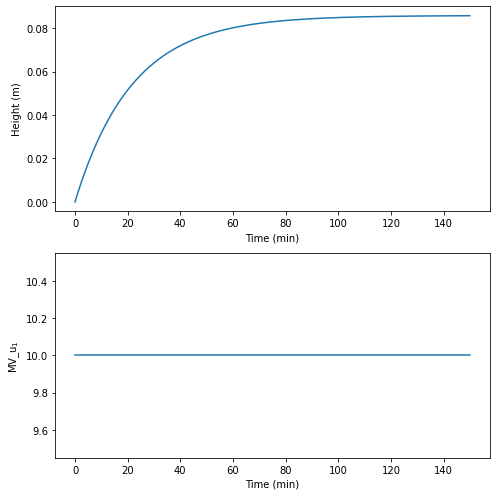

In [ ]:
fig,[ax1,ax2] = plt.subplots(2,1,figsize = (7,7))

ax1.plot(tspan,y_ol_list - y0[0])  #deviation variables
ax1.set_ylabel('Height (m)')
ax1.set_xlabel('Time (min)')

input_ = np.array([MV_u1(ti) for ti in tspan])   # calculating the array of w1 to graph!!

ax2.plot(tspan,input_ - 120)
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('MV_u$_{1}$')

plt.tight_layout()

plt.show()

## FOPDT Fitting of the step change response

In [ ]:
def FOPDT_step(t,K,tau,theta): 
    
    y_array = []

    
    for t in t:
    
        if t < theta :
        
            y_array.append(0)
     
    
        if t >= theta:
        
            y_array.append( K*M_step*(1 - np.e**(-(t-theta)/tau ) ))
        
    return y_array   

In [ ]:
response_step = FOPDT_step(tspan,0.008,20,0)  #values guessed from openloop response curve

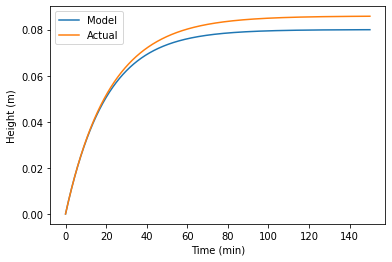

In [ ]:
plt.plot(tspan,response_step, label = 'Model')          #in deviation variables
plt.plot(tspan,y_ol_list -  y0[0] , label = 'Actual')         
plt.xlabel('Time (min)')
plt.ylabel('Height (m)')
plt.legend( loc = 'best')

## Optimisng the FOPDT parameters with curve fitting and plotting the resulting model with the actual response

In [ ]:
p0 = [0.008,20,0]
params2 = curve_fit(FOPDT_step,tspan, y_ol_list -  y0[0] ,p0 , bounds = (0,100) ) #optimize the parameters 

In [ ]:
params_step = params2[0]

In [ ]:
params_step

array([8.58169984e-03, 2.18399165e+01, 8.48544206e-19])

The curve fit solver has a bound so ensure that tau and theta are positive values. Since M is positive, K will be positive as well.

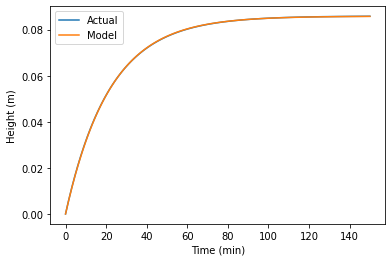

In [ ]:
plt.plot(tspan, y_ol_list -  y0[0], label = 'Actual')
plt.plot(tspan,FOPDT_step(tspan,*params_step) , label = 'Model') #plot the results 

plt.xlabel('Time (min)')
plt.ylabel('Height (m)')
plt.legend( loc = 'best')
plt.show()

In [ ]:
K_step, tau_step , theta_step = params_step

print(f'K = {round(K_step,4)}')
print(f'tau = {round(tau_step,4)} min')
print(f'theta = {round(theta_step,4)} min')

K = 0.0086
tau = 21.8399 min
theta = 0.0 min


Using a step change in u1, it is evident that the process does not have a time delay. The solved theta is miniscule.

# Controller tuning and test with an appropriate step change in the setpoint

Controlled variable : y (height)

Manipulated variable : u1 (w1)

A possible change in the setpoint could be for the height to be higher to increase productivity of the whole plant.

In [ ]:
y_new_sp = 1.5 #m           Arbitrarily chosen
M_sp = y_new_sp - y0[0]   #step change magnitude
print(f' Magnitude of setpoint step change = {round(M_sp,4)} m')

 Magnitude of setpoint step change = 0.3685 m


To implement a control system, a feedback loop has to be set up with the following components:

* the process
* a sensor and transmitter of the height (controlled variable)
* a controller that takes the error of the height setpoint and height measurement.
* a conversion of the setpoint into a current signal before the error is calculated
* a pressure/current transducer that converts the current signal from the controller to a pressure input for the control valve
* a valve(final controller element) that manipulates w1 (manipulated variable)
* the distubance (w2)

It is assumed for now that only the process, disturbance and controller have dynamics and that all other elements in the control loop have negligible dynamics and all have gains of 1.

Therefore $$ G = G_pG_{IP}G_vG_m = \frac{K_p e^{-\theta s}}{\tau_p s + 1} $$

In [ ]:
Kp = float(K_step)         # m/kg/min
tau_p = float(tau_step)    #minutes
theta = 0  #minutes

To find the preliminary controller parameters, the SIMC tuning relations will be used.

In [ ]:
from scipy import signal

## 1. PID controller

## Preliminary design

An ideal PID controller is
$$ G_c = K_c \left(1 + \frac{1}{\tau_Is} + \tau_Ds \right) $$ 

This is physically unrealistic due to the positive zero from the derivative control.

A physically realistic controler transfer funtion is
$$ G_c = K_c \left(1 + \frac{1}{\tau_Is} + \frac{\tau_Ds}{\alpha\tau_Ds +1} \right) $$ 

which can be rewritten as
$$ G_c = \frac{K_c(\alpha\tau_I\tau_D + \tau_I\tau_D)s^2 + K_c(\tau_I + \alpha\tau_D)s + K_c}{\alpha\tau_I\tau_D s^2 + \tau_Is} $$ 

with $\alpha$ being a constant used for this derivative mode filter.


In [ ]:
alpha = 0.1              #typical value

## a) Controller parameter calculation

In [ ]:
tau_c = 0.5

Kc_prelim = 1/Kp * (tau_p/tau_c)
tau_I_prelim = min(tau_p , 4*(tau_c))        
tau_D_prelim = 3                            #guessed

print(f' Kc = {Kc_prelim}')
print(f' tau_I = {tau_I_prelim}')
print(f' tau_D = {tau_D_prelim}')

 Kc = 5089.881236017252
 tau_I = 2.0
 tau_D = 3


## d) Defining a simulation time span and step time

In [ ]:
dt_max = 0.01*tau_p
dt_max*3600  #seconds

786.2369941935312

In [ ]:
dt_max2 = 0.1*tau_I_prelim
dt_max2*3600 #seconds

720.0

In [ ]:
Tspan = np.linspace(0,80,20000)  # time span for the simulation [min]

dt = Tspan[1] - Tspan[0] 
dt*3600                            # minutes -smaller than both dt_max

14.4007200360018

## b) Calculating the array of the setpoint change

In [ ]:
def Y_sp(t):              
    
    if t < 0:
        
        return  y0[0]    #initial steady state y value
    
    if t >= 0:
        
        return float(y_new_sp)


Ysp_array = [Y_sp(ti) for ti in Tspan]   

## c) Redefining the system equations to include an additional input

The other controller input y_m is calculated using the process equations seen below

In [ ]:
def intsys_control(t,y,MV):  #adding an extra input 
    
    if y < 1:
    
        q = 0
        
    else:
         q = 0.025*np.sqrt(y-1)   
            
    w_leak = rho*q                
    
    dy_dt = (1/(rho*A))*( MV + MV_u2(t) - w_leak - Cv*np.sqrt(y) )
    
    return dy_dt

## e) Defining the function that calculated the measured y values with the controller parameters as inputs

In [ ]:
def PID_sim(Kc,tau_I,tau_D):
    
    def PID_LTI(Kc,tau_I,tau_D):                   #Creating the state space controller function -> A, B, C, D matrices
    
        Gc_num_s2 = Kc*(tau_I*tau_D )*(alpha + 1) #coefficients of s^2 in the controller numerator
        Gc_num_s1 = Kc*(tau_I + alpha*tau_D)       #coefficients of s^1 in the controller numerator
        Gc_num_s0 = Kc                             #coefficients of s^0 in the controller numerator

        Gc_deno_s2 = alpha*tau_I*tau_D             #coefficients of s^2 in the controller denominator
        Gc_deno_s1 = tau_I                         #coefficients of s^1 in the controller denominator
        Gc_deno_s0 = 0                             #coefficients of s^0 in the controller denominator
    
        Gc_PID = signal.lti([Gc_num_s2,Gc_num_s1,Gc_num_s0],[Gc_deno_s2,Gc_deno_s1,Gc_deno_s0]).to_ss() #defining the PID controller
        return Gc_PID

    
    
    def PID_controller(ysp , ym):                   #2 inputs of controller = setpoint y and the previous measured y value in mA
    
        e = ysp - ym                                #error
    
        Gc_PID = PID_LTI(Kc,tau_I,tau_D)
    
        dpcdt = Gc_PID.A.dot(pc) + Gc_PID.B.dot(e)  
    
        yc = Gc_PID.C.dot(pc) + Gc_PID.D.dot(e)
    
        p = p0 + yc[0,0]                            #the total signal p out of the controller with the bias
    
        return p, dpcdt
    
    
    y_PID = []        
    
    y_m = y0[0]                                      #the initial measured h would be the previous setpoint
    p0 = 120                                         #kg/min 
    
    Gc_PID = PID_LTI(Kc,tau_I,tau_D)
    pc = np.zeros([Gc_PID.A.shape[0],1]) 
    
    for t in Tspan:
    
        y_PID.append(y_m)
    
        y_sp = Y_sp(t)                               #setpoint change
    
        p_out = PID_controller(y_sp, y_m)[0]         #p_out = input of process = w1
    
        derivative = intsys_control(t, y_m , p_out)
    
        y_m += derivative*dt
    
        pc += PID_controller(y_sp, y_m)[1]*dt
        
    return y_PID                                      #final array of measured y values

## f) Simulation and plotting of the measured y values with PID control

In [ ]:
PID_prelim = PID_sim(Kc_prelim,tau_I_prelim,tau_D_prelim)

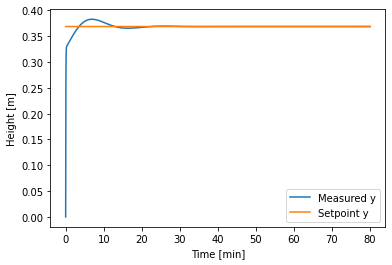

In [ ]:
plt.plot(Tspan , PID_prelim - y0[0]  , label = 'Measured y')    # in deviation variables
plt.plot(Tspan , Ysp_array - y0[0]  , label = 'Setpoint y')
plt.xlabel('Time [min]')
plt.ylabel('Height [m]')
plt.legend(loc = 'best')
plt.show()

The controlled response is adequate but the preliminary controller parameter can be fine tuned for a better performing controller.

## Revised design

For the above PID controller, by setting $\tau_D$ equal to zero give a stable PI controlled loop. Thus $\tau_D$ was guess by trial and error to get a stable response.

The Kc was also reduced for a more robust controller.

In [ ]:
tau_D_new = 3

In [ ]:
PID_new = PID_sim(0.1*Kc_prelim,tau_I_prelim,tau_D_new)

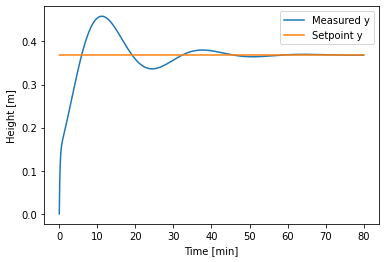

In [ ]:
plt.plot(Tspan , PID_new - y0[0]  , label = 'Measured y')      # in deviation variables
plt.plot(Tspan , Ysp_array - y0[0]  , label = 'Setpoint y')
plt.xlabel('Time [min]')
plt.ylabel('Height [m]')
plt.legend(loc = 'best')
plt.show()

The settling time of around 60 minutes could be improved by increase Kc.

The initial derivative kick is not too high for an overflow. This derivative does not need to be reduced for these parameters

## 2. P, PI and PD controller

The previous PID function can be used but with $\tau_I$ and $\tau_D$ set very large and very small respecively for a P controller. For the PI controller, just the $\tau_D$ is set very small and for a PD controller, $\tau_I$ set very large.

/usr/local/lib/python3.7/dist-packages/scipy/signal/filter_design.py:1622: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


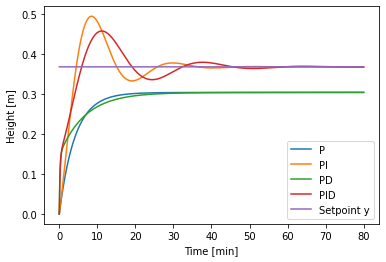

In [ ]:
P_new = PID_sim(0.1*Kc_prelim,10000,0)
PI_new = PID_sim(0.1*Kc_prelim,tau_I_prelim,0)
PD_new = PID_sim(0.1*Kc_prelim,10000,tau_D_new)

plt.plot(Tspan , P_new - y0[0]  , label = 'P') 
plt.plot(Tspan , PI_new - y0[0]  , label = 'PI')
plt.plot(Tspan , PD_new - y0[0]  , label = 'PD')
plt.plot(Tspan , PID_new - y0[0]  , label = 'PID')

plt.plot(Tspan , Ysp_array - y0[0]  , label = 'Setpoint y')
plt.xlabel('Time [min]')
plt.ylabel('Height [m]')
plt.legend(loc = 'best')
plt.show()

It can be seen that the P and PD controllers do not reach the desired set point hence they cannot be used for this project. PI controller reaches the set point but has large overshoot and longer settling time. The PID controller is the best controller for this projeft due to its reasonable overshoot and shorter settling time.

# Part 2

## Final parameters from part 1

In [ ]:
Kc = 0.1*Kc_prelim
tau_I = tau_I_prelim
tau_D = tau_D_new

print(f' Kc = {Kc}')
print(f' tau_I = {tau_I}')
print(f' tau_D = {tau_D}')

 Kc = 508.98812360172525
 tau_I = 2.0
 tau_D = 3


## Time linspace, delta T and sampling time

The same time linspace and delta T used for the continuous controller will be used since the process differential equations are still calculated contiously.

The discrete controller outputs calculated using the positon or velocity form will be calculated using the newly defined sampling period instead. According to Seborg et al. (2017), this sampling period should be between 1% and 5% of the process time constant.



In [ ]:
t_sample_average = 0.03*tau_p   #minutes
t_sample_average

0.655197495161276

In [ ]:
t_sample = dt*164
t_sample  #using a multiple of dt to ensure ease of coding

0.656032801640082

# Position form:

In [ ]:
def PID_position(Kc,tau_I,tau_D): #to determine response of system once while guessing Kc, taui, taud
      
    
    y_PID = []        
    y_m = y0[0]                                      #the initial measured h would be the previous setpoint
    
    p0 = 120                                         #kg/min - controller bias value = steady state value of the manipulated variable

    eks = [0]
    ysp_lst = []
    
    MV_lst = [p0]
    
    
    for t in Tspan:

        y_PID.append(y_m)

        y_sp = Y_sp(t)            #setpoint change
        ysp_lst.append(y_sp)

        if t % t_sample != 0 :                       #Zero order hold of the controller output between sampling times 
            pk = MV_lst[-1]
            MV_lst.append(pk)

        else:
           
            ek = y_sp - y_m
            eks.append(ek)
        
            ekmin1 = eks[-2]

            pk = p0 + Kc * (ek + t_sample*sum(eks)/tau_I + tau_D*(ek - ekmin1)/t_sample)    #controller output calculation

            if pk <= 0:                                                  #saturation limits for the controller output
                pk = 0
                MV_lst.append(pk)

            if pk >= 240:      #assuming steady state is 50% valve opening
                pk = 240
                MV_lst.append(pk)

        
        derivative = intsys_control(t, y_m, pk)     #continuous process calculation
        y_m += derivative*dt
        
    return y_PID, MV_lst

## 1) PID Controller

In [ ]:
Y_pos , MV_pos = PID_position(Kc,tau_I,tau_D)

In [ ]:
len(MV_pos)

19992

ValueError: ignored

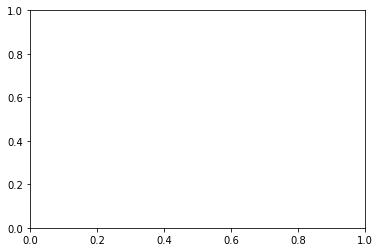

In [ ]:
plt.plot(Tspan,MV_pos[1:])  
plt.xlabel('Time (min)')
plt.ylabel('Flowrate (kg/min)')
plt.title("PID controller output in position form")
plt.show()

In [ ]:
plt.plot(Tspan,Y_pos - y0[0], label = 'Measured y (Discrete)')  
plt.plot(Tspan, Ysp_array - y0[0], label = 'Setpoint y')
plt.xlabel('Time (min)')
plt.ylabel('Height (m)')
plt.legend(loc = 'best')
plt.title("PID controller in position form")
plt.show()

For the parameters (Kc, $\tau_I$ and $\tau_D$) determined in part 1, the discrete PID controller in velocity form initially produces a noisy response. The response later improves and the discrete controller output gives reasonable overshoot although with a long settling time. 

This is due to the longer sampling time which results in some information loss with discrete control and some noisy controller outputs. The smoothing out of control could be due to the fact that this process is not fast acting ( $\tau_p$ is around 21 minutes) so the sampled measurements do not differ much between sampling periods.

## 2. P, PI and PD controller and comparison with the PID controller

In [ ]:
P_pos = PID_position(Kc,100000000,0)[0]
PI_pos = PID_position(Kc,tau_I,0)[0]
PD_pos = PID_position(Kc,100000000,tau_D)[0]

plt.plot(tspan , P_pos - y0[0]  , label = 'P') 
plt.plot(tspan , PI_pos - y0[0]  , label = 'PI')
plt.plot(tspan , PD_pos - y0[0]  , label = 'PD')
plt.plot(tspan , PID_pos - y0[0]  , label = 'PID')

plt.plot(tspan , Ysp_array - y0[0]  , label = 'Setpoint y')
plt.xlabel('Time [min]')
plt.ylabel('Height [m]')
plt.legend(loc = 'best')
plt.show()

The position form discrete controllers (except the PI and P controller) exhibit similar behaviour i.e. initially noisy response which later improves. The PI controller however has a larger overshoot and seemingly shorter settling time than the others. A PI controller would be the preferred position form discrete controller for the assigned system. 

The controllers with derivative action would be faster which explains the initial noisy control variable.

## 3. Comparison of the discrete and continous PID controller

In [ ]:
plt.plot(tspan , PID_pos - y0[0]  , label = 'PID Discrete')
plt.plot(Tspan, PID_new - y0[0], label = 'PID Continuous') 
    
plt.plot(tspan, Ysp_array - y0[0], label = 'Setpoint y')
plt.xlabel('Time (min)')
plt.ylabel('Height (m)')
plt.title("Discrete and continous PID controller")
plt.legend(loc = 'best')
plt.show()

The continuous and discrete controllers perform similarly except for the initial noise from the discrete controller.

A continuous controller could be preferred to protect the control value from frequent motion. The discrete controller could be used if the cost benefits are large enough since the control between the two is similar.

# Velocity form:

In [ ]:
def PID_velocity(Kc,tau_I,tau_D): 
      
    y_PID = []        
    y_m = y0[0]                                      
    
    p0 = 120                                        #kg/min 
    MV_lst = []

    eks = [0,0]
    ysp_lst = []
    
    for t in Tspan:

        y_PID.append(y_m)

        MV_lst.append(p0)
    
        y_sp = Y_sp(t)     #setpoint change
        ysp_lst.append(y_sp)

        if t % t_sample != 0:                       #Zero order hold of the controller output between sampling times 
            p0 = MV_lst[-1]

        else:
        
            ek = y_sp - y_m
            eks.append(ek)
        
            ekmin1 = eks[-2]
            ekmin2 = eks[-3]
      
            deltapk = Kc * (ek - ekmin1 + t_sample*ek/tau_I + tau_D/t_sample * (ek - 2*ekmin1 + ekmin2))
            p0 += deltapk 
        
        derivative = intsys_control(t, y_m, p0)
        
        y_m += derivative*dt
        
    return y_PID, MV_lst                                    #final array of measured y values

## 1. PID Controller

In [ ]:
PID_vel, MV_vel = PID_velocity(Kc,tau_I,tau_D)

In [ ]:
plt.plot(Tspan[0:500],MV_vel[0:500], 'r*')  
plt.xlabel('Time (min)')
plt.ylabel('Flowrate (kg/min)')
plt.title("PID controller output in velocity form")
plt.show()

In [ ]:
plt.plot(Tspan,PID_vel - y0[0], label = 'Measured y (Discrete)')  
plt.plot(Tspan, Ysp_array - y0[0], label = 'Setpoint y')
plt.xlabel('Time (min)')
plt.ylabel('Height (m)')
plt.title("PID controller in velocity form")
plt.show()

Similar to the position form, the response is initially noisy but improves with time. Again, the settling time is large at around 50 minutes. This could be improved with a higher $K_c$ or $\tau_D$ value but would result in more oscillatory behavior.

## 2. P, PI and PD controller and comparison with the PID controller

In [ ]:
P_vel = PID_velocity(Kc,100000000,0)
PI_vel = PID_velocity(Kc,tau_I,0)
PD_vel = PID_velocity(Kc,100000000,tau_D)

plt.plot(tspan , P_vel - y0[0]  , label = 'P') 
plt.plot(tspan , PI_vel - y0[0]  , label = 'PI')
plt.plot(tspan , PD_vel - y0[0]  , label = 'PD')
plt.plot(tspan , PID_vel - y0[0]  , label = 'PID')

plt.plot(tspan , Ysp_array - y0[0]  , label = 'Setpoint y')
plt.xlabel('Time [min]')
plt.ylabel('Height [m]')
plt.legend(loc = 'best')
plt.show()

## 3. Comparison of the discrete and continous PID controller

In [ ]:
plt.plot(tspan , PID_vel - y0[0]  , label = 'PID Discrete')
plt.plot(Tspan, PID_new - y0[0], label = 'PID Continuous') 
    
plt.plot(tspan, Ysp_array - y0[0], label = 'Setpoint y')
plt.xlabel('Time (min)')
plt.ylabel('Height (m)')
plt.title("Discrete and continous PID controller")
plt.legend(loc = 'best')
plt.show()

## 4. Comparison of the position and velocity PID controllers

In [ ]:
PID_vel_new = PID_velocity(Kc,tau_I,tau_D)
PID_pos_new = PID_position(Kc,tau_I,tau_D)[0]


plt.plot(tspan , PID_vel_new - y0[0]  , label = 'PID Velocity form')
plt.plot(tspan , PID_pos_new - y0[0]  , label = 'PID Position form')
plt.plot(Tspan, PID_new - y0[0], label = 'PID Continuous') 
    
plt.plot(tspan, Ysp_array - y0[0], label = 'Setpoint y')
plt.xlabel('Time (min)')
plt.ylabel('Height (m)')
plt.title("Position and velocity form PID controller")
plt.legend(loc = 'best')
plt.show()  

The position form and velocity form discrete PID controllers are identical since the initial value of the manipulated variable is the same. The velocity form does have some flexibility in this initial control valve position since it just calculates the change for the controller output and thus also of the manipulated variable.

In [ ]:
tspan = np.linspace(0,80,122)
dt_now = tspan[1] - tspan[0]
dt_now

In [ ]:
bspan = np.linspace(0,10,11)
bt = bspan[1] - bspan[0]
b_sample = 2*bt
b_sample

2.0

In [ ]:
F = 9
test = []

for count,T in enumerate(bspan):
  
  if count+1 % 2 != 0: 
    test.append(F)
    F = test[-1]
    

  else:
    F = 12
    test.append(F)

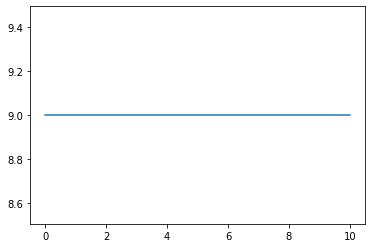

In [ ]:
plt.plot(bspan , test)
plt.show()